# Imports

In [2]:
%load_ext autoreload
%autoreload 2

import skimage
import os
import glob
import importlib
import wandb
import re
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import egg_class_functions as ecf
import tensorflow as tf
import albumentations as A
import multiprocessing as mp
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras
from tensorflow.data import AUTOTUNE

importlib.reload(ecf)

2025-09-23 16:29:33.973900: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-23 16:29:33.995863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758637774.007562     384 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758637774.010235     384 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758637774.026475     384 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

<module 'egg_class_functions' from '/home/tibor/Documents/Python/mosquito-egg-identification/egg_class_functions.py'>

# Variable setup

In [ ]:
seg_data_path = "Data/processed/predicted_segmentation_data.csv"
image_paths = sorted(glob.glob("Data/raw/*/**/*.*", recursive=True), key=lambda x: (os.path.dirname(x), os.path.basename(x)))
metrics_csv = "Data/processed/model_metrics.csv"
BATCH_SIZE = 16
EPOCHS = 50
SEEDS = [2, 4, 6, 8, 10]
FINE_TUNE_EPOCHS = 20
height = 200
width = 100

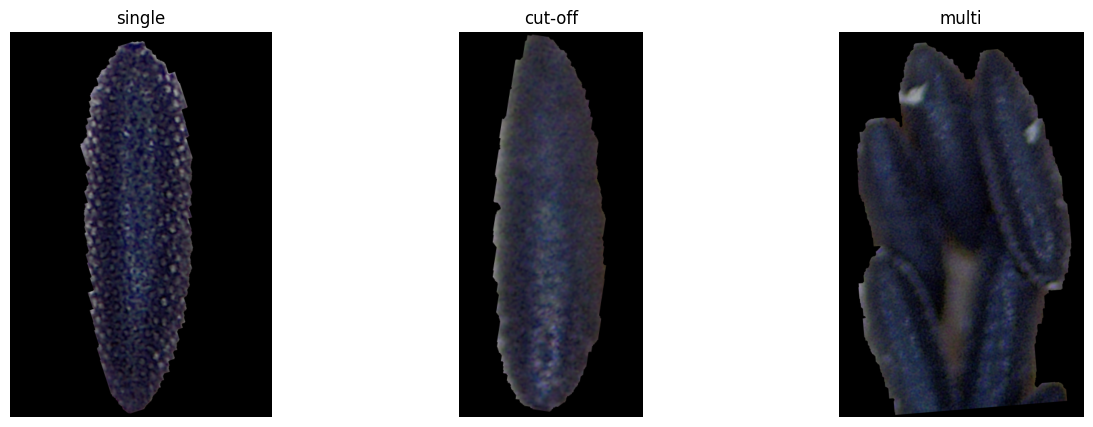

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
seg_data_path = "Data/processed/predicted_segmentation_data.csv"

# Beispiel: df enthält die Spalten ['filepath', 'single', 'cut_off', 'multi']
df = pd.read_csv(seg_data_path)
df["segment_path"] = df["segment_path"].astype(str)
# Mapping: Klasse -> Spalte
classes = {
    "single": "single",
    "cut-off": "cut-off",
    "multi": "multi"
}

# Für jede Klasse ein Beispielbild anzeigen
fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))

for ax, (label, col) in zip(axes, classes.items()):import numpy as np
import pandas as pd
import matplotlib.pyplot as dddasdasdfsdfdsfdsfdf
    # Ersten Index für diese Klasse finden
    idx = df.index[df[col] == 1][292]
    
    # Bildpfad laden
    img_path = df.loc[idx, "segment_path"]
    img = skimage.io.imread(img_path)
    
    # Plotten
    ax.imshow(img)
    ax.set_title(label)
    ax.axis("off")

plt.show()


In [3]:
df_pred = ecf.segmented_image_import(seg_data_path)

for i, row in df_pred.iterrows():
    if row["device"] == "microscope":
        m = re.match(r"(ag|ap)_(\d+)", str(row["name"]))
        if m:
            num = int(m.group(2))
            if 1 <= num <= 200:
                df_pred.at[i, "age"] = "prior"
            elif 201 <= num <= 400:
                df_pred.at[i, "age"] = "fresh"
            elif 401 <= num <= 600:
                df_pred.at[i, "age"] = "dried"
    elif row["device"] == "phone":
        date = str(row["name"])[:10] 
        if date in ["2025-08-06", "2025-08-07"]:
            df_pred.at[i, "age"] = "fresh"
        elif date == "2025-08-12":
            df_pred.at[i, "age"] = "dried"


df_pred = df_pred.dropna()
results = df_pred.apply(ecf.pad_rgb_segment, output_shape=(height, width), axis=1)
df_pred["segment"] = results.apply(lambda x: x["segment"])
df_pred["mask"] = results.apply(lambda x: x["mask"])
df_pred['species'] = df_pred['species'].replace("aegypti_old", "aegypti")
df_pred['species'] = df_pred['species'].replace("albopictus_old", "albopictus")

X_train = df_pred.loc[:, ['segment', 'mask']]
y_train = df_pred['species']
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_train_onehot = to_categorical(y_train_encoded)

X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train, y_train_onehot, test_size=0.2, random_state=42)

test_ds = ecf.prepare_dataset_alb(X_test_split, y_test_split, None, BATCH_SIZE, shuffle=False)

I0000 00:00:1758604724.106246     545 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6604 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [4]:
color_trans = A.Compose([
# Image Capture Variance
A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=.5),
A.PlanckianJitter(p=.5),
A.ImageCompression(quality_lower=80, quality_upper=100, p=.25),
A.Defocus(radius=(1, 3), p=.25),
A.RandomGamma(gamma_limit=(80, 120), p=.25),
A.MotionBlur(blur_limit=(3, 3), p=.25),
A.Downscale(scale_min=0.8, scale_max=1, p=.25),
# Color Changes
A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=.5),
A.ChannelDropout(channel_drop_range=(1, 1), p=.25),
A.RandomShadow(shadow_roi=(0.3,0,0.7,1),p=0.25),
# Noise
A.MultiplicativeNoise(multiplier=(0.9, 1.1), per_channel=True, p=.25),
A.HorizontalFlip(p=0.5),
A.VerticalFlip(p=0.5),
A.ShiftScaleRotate(shift_limit=(0, 0.0625), scale_limit=0.0, rotate_limit=(-5, 5), p=0.5),
])


def albumentations_augment(image, mask):
    image = image.astype(np.uint8)
    augmented = color_trans(image=image)
    #augmented = augmented * mask

    aug_image = augmented['image'].astype(np.float32)
    aug_image *= mask[..., np.newaxis]

    return aug_image


def tf_albumentations_augment(image, mask, label):
    aug_image = tf.numpy_function(albumentations_augment, [image, mask], tf.float32)
    aug_image.set_shape(image.shape)
    return aug_image, mask, label

/tmp/ipykernel_65346/1552556142.py:5: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=80, quality_upper=100, p=.25),
/tmp/ipykernel_65346/1552556142.py:9: UserWarning: Argument(s) 'scale_min, scale_max' are not valid for transform Downscale
  A.Downscale(scale_min=0.8, scale_max=1, p=.25),
/home/tibor/Documents/Python/mosquito-egg-identification/venv/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
for subset_name, filter_func in {
    "all": lambda df: df,
    "microscope": lambda df: df[(df['device'] == 'microscope') & (df['age'] != 'prior')],
    "phone": lambda df: df[df['device'] == 'phone'],
    "fresh": lambda df: df[df['age'] == 'fresh'],
    "dried": lambda df: df[df['age'] == 'dried'],
    "comparison": lambda df: df[df['age'].isin(['fresh', 'dried'])]
}.items():
    
    df_sub = filter_func(df_pred)
    if len(df_sub) == 0:
        continue
    print(f"{len(df_sub)} images in {subset_name} mit \n {df_sub.groupby(["species"]).size()}")

1881 images in all 
810 images in microscope 
464 images in phone 
770 images in fresh 
504 images in dried 
1274 images in comparison 


In [15]:
for subset_name, filter_func in {
    "all": lambda df: df,
    "microscope": lambda df: df[(df['device'] == 'microscope') & (df['age'] != 'prior')],
    "phone": lambda df: df[df['device'] == 'phone'],
    "fresh": lambda df: df[df['age'] == 'fresh'],
    "dried": lambda df: df[df['age'] == 'dried']
}.items():

    df_sub = filter_func(df_pred)

    X = df_sub.loc[:, ['segment', 'mask']]
    y = df_sub['species']

    # Labels encoden
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_onehot = to_categorical(y_encoded)

    # Train/Test-Split (immer gleich, z. B. mit random_state=42)
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
        X, y_onehot, test_size=0.2, random_state=42
    )

    test_ds = ecf.prepare_dataset_alb(X_test_split, y_test_split, None, BATCH_SIZE, shuffle=False)



    #for seed in SEEDS:
    X_training, X_val, y_training, y_val = train_test_split(X_train_split, y_train_split, test_size=0.2, random_state=seed)

    train_ds = ecf.prepare_dataset_alb(X_training, y_training, tf_albumentations_augment, BATCH_SIZE)
    val_ds = ecf.prepare_dataset_alb(X_val, y_val, None, BATCH_SIZE, shuffle=False)

    print(f"Subset {subset_name}")
    print("Train samples:", len(X_training))
    print("Val samples:", len(X_val))
    print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
    print("Val batches:", tf.data.experimental.cardinality(val_ds).numpy())


Subset all
Train samples: 1203
Val samples: 301
Train batches: 76
Val batches: 19
Subset microscope
Train samples: 518
Val samples: 130
Train batches: 33
Val batches: 9
Subset phone
Train samples: 296
Val samples: 75
Train batches: 19
Val batches: 5
Subset fresh
Train samples: 492
Val samples: 124
Train batches: 31
Val batches: 8
Subset dried
Train samples: 322
Val samples: 81
Train batches: 21
Val batches: 6


In [ ]:
for subset_name, filter_func in {
    "all": lambda df: df,
    "microscope": lambda df: df[(df['device'] == 'microscope') & (df['age'] != 'prior')],
    "phone": lambda df: df[df['device'] == 'phone'],
    "fresh": lambda df: df[df['age'] == 'fresh'],
    "dried": lambda df: df[df['age'] == 'dried']
}.items():
    
    df_sub = filter_func(df_pred)
    if len(df_sub) == 0:
        continue
df_sub = df_pred[df_pred['age'] == 'dried']

for seed in SEEDS:

    train_ds = ecf.prepare_dataset_alb(X_training, y_training, tf_albumentations_augment, BATCH_SIZE)
    val_ds = ecf.prepare_dataset_alb(X_val, y_val, None, BATCH_SIZE, shuffle=False)



#weight_for_albo = (1 / sum(single_egg_df['species'] == 'albopictus')) * (len(single_egg_df))
#weight_for_aegy = (1 / sum(single_egg_df['species'] == 'aegypti')) * (len(single_egg_df))

#class_weight = {0: weight_for_albo, 1: weight_for_aegy}
#print('Weight for class 0: {:.2f}'.format(weight_for_albo))
#print('Weight for class 1: {:.2f}'.format(weight_for_aegy))

    
    base_model = tf.keras.applications.EfficientNetV2B0(
        input_shape=(height, width, 3),
        include_top=False,
        weights="imagenet"
    )
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        layers.Flatten(),
        #layers.GlobalAveragePooling2D(),
        #layers.GlobalMaxPooling2D(),
        #layers.Dropout(rate=0.25),
        layers.Dense(128, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])


    wandb.init(project="egg-classification", 
        name=model_name,
        config={
        "architecture": "EfficientNetV2B0",
        "input_shape": (height, width, 3),
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "optimizer": "nadam",
        "loss": "categorical_crossentropy",
        "num_classes": 2
    })


    #local_checkpoint = ModelCheckpoint(
    #    filepath=f"models/{model_name}/model.weights.h5",
    #    save_best_only=True,
    #    save_weights_only=True
    #)

    #wandb_checkpoint = WandbModelCheckpoint(
    #    filepath="models-wandb/model-{epoch:02d}.keras",
    #    save_best_only=True
    #)

    optimizer = keras.optimizers.Nadam(learning_rate=0.0001)

    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'],
                )
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(train_ds,
                        epochs=EPOCHS,
                        validation_data=val_ds,
                        callbacks=[WandbMetricsLogger(),
                                #wandb_checkpoint,
                                early_stop                              
                                    ],
                        #class_weight=class_weight
                        )
    
    model.save("tmp_model.h5")
    del model
    tf.keras.backend.clear_session()
    gc.collect()

    model = keras.models.load_model("tmp_model.h5")
    
    fine_tune_at = int(len(base_model.layers) * 0.8)

    for i, layer in enumerate(base_model.layers):
        if i >= fine_tune_at:
            layer.trainable = True
        else:
            layer.trainable = False

    optimizer = keras.optimizers.Nadam(learning_rate=0.00001)
    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'],
                )


    history = model.fit(train_ds,
                        epochs=FINE_TUNE_EPOCHS,
                        validation_data=val_ds,
                        callbacks=[WandbMetricsLogger(),
                                #wandb_checkpoint,
                                early_stop                              
                                    ],
                        #class_weight=class_weight
                        )

    y_val_true = []
    y_val_pred = []

    for x, y in val_ds:
        preds = model.predict(x)
        y_val_true.extend(np.argmax(y.numpy(), axis=1))
        y_val_pred.extend(np.argmax(preds, axis=1))

    #cm = confusion_matrix(y_val_true, y_val_pred)
    #wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(
    #    probs=None,
    #    y_true=y_val_true,
    #    preds=y_val_pred,
    #    class_names=["aegypti", "albopictus"]
    #)})

    y_test_true = []
    y_test_pred = []

    for x, y in test_ds:
        preds = model.predict(x)
        y_test_true.extend(np.argmax(y.numpy(), axis=1))
        y_test_pred.extend(np.argmax(preds, axis=1))

    metrics = {
        "model": model_name,
        "accuracy_val": accuracy_score(y_val_true, y_val_pred),
        "precision_val": precision_score(y_val_true, y_val_pred, average='macro'),
        "recall_val": recall_score(y_val_true, y_val_pred, average='macro'),
        "f1_val": f1_score(y_val_true, y_val_pred, average='macro'),
        "accuracy_val": accuracy_score(y_val_true, y_val_pred),
        "precision_val_w": precision_score(y_val_true, y_val_pred, average='weighted'),
        "recall_val_w": recall_score(y_val_true, y_val_pred, average='weighted'),
        "f1_val_w": f1_score(y_val_true, y_val_pred, average='weighted'),
        "accuracy_test": accuracy_score(y_test_true, y_test_pred),
        "precision_test": precision_score(y_test_true, y_test_pred, average='macro'),
        "recall_test": recall_score(y_test_true, y_test_pred, average='macro'),
        "f1_test": f1_score(y_test_true, y_test_pred, average='macro'),
        "precision_test_w": precision_score(y_test_true, y_test_pred, average='weighted'),
        "recall_test_w": recall_score(y_test_true, y_test_pred, average='weighted'),
        "f1_test_w": f1_score(y_test_true, y_test_pred, average='weighted'),
    }

    df_metrics = pd.DataFrame([metrics])
    if os.path.exists(metrics_csv):
        df_metrics.to_csv(metrics_csv, mode='a', header=False, index=False)
    else:
        df_metrics.to_csv(metrics_csv, index=False)

    wandb.finish()
    del model, history, metrics, train_ds, val_ds
    tf.keras.backend.clear_session()
    gc.collect()

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.5049 - loss: 0.9675 - val_accuracy: 0.5050 - val_loss: 0.7467
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5436 - loss: 0.6999 - val_accuracy: 0.5581 - val_loss: 0.7173
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5825 - loss: 0.6872 - val_accuracy: 0.6279 - val_loss: 0.6554
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6106 - loss: 0.6637 - val_accuracy: 0.6545 - val_loss: 0.6194
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6461 - loss: 0.6626 - val_accuracy: 0.7110 - val_loss: 0.5942
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6247 - loss: 0.6535 - val_accuracy: 0.5648 - val_loss: 0.7842
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6133 - loss: 0.6615 - val_accuracy: 0.6246 - val_loss: 0.6345
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6317 - loss: 0.6379 - val_accuracy: 0.6611 - val_lo

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.6576 - loss: 0.6058 - val_accuracy: 0.7143 - val_loss: 0.5757
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6995 - loss: 0.5796 - val_accuracy: 0.6877 - val_loss: 0.5853
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6621 - loss: 0.5898 - val_accuracy: 0.6977 - val_loss: 0.5830
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6724 - loss: 0.6137 - val_accuracy: 0.7143 - val_loss: 0.5796
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7047 - loss: 0.5673 - val_accuracy: 0.7176 - val_loss: 0.5766
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6901 - loss: 0.5834 - val_accuracy: 0.7076 - val_loss: 0.5775
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch/accuracy,▁▃▄▄▅▅▆▆▅▆▆▆▆▆▇▇▆▇▇▇▇███
epoch/epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██▁▁▂▂▃▃
epoch/learning_rate,██████████████████▁▁▁▁▁▁
epoch/loss,█▄▄▃▄▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁
epoch/val_accuracy,▁▃▅▆█▃▅▆▆▆▆█▇▆▅▇▇▇█▇▇███
epoch/val_loss,▇▆▄▂▂█▃▁▃▂▃▂▁▂▅▂▂▂▁▁▁▁▁▁
epoch/accuracy,0.67997
epoch/epoch,5
epoch/learning_rate,1e-05
epoch/loss,0.59117
epoch/val_accuracy,0.70764


Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.5447 - loss: 0.8678 - val_accuracy: 0.6146 - val_loss: 0.6645
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5697 - loss: 0.6807 - val_accuracy: 0.6179 - val_loss: 0.6512
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6037 - loss: 0.6728 - val_accuracy: 0.6213 - val_loss: 0.6308
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6044 - loss: 0.6687 - val_accuracy: 0.6246 - val_loss: 0.6568
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6237 - loss: 0.6502 - val_accuracy: 0.6512 - val_loss: 0.6344
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6383 - loss: 0.6358 - val_accuracy: 0.6213 - val_loss: 0.6329
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6375 - loss: 0.6490 - val_accuracy: 0.6512 - val_loss: 0.6011
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5792 - loss: 0.6566 - val_accuracy: 0.6645 - val_lo

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.6998 - loss: 0.5774 - val_accuracy: 0.6910 - val_loss: 0.5672
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7104 - loss: 0.5475 - val_accuracy: 0.6910 - val_loss: 0.5752
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7031 - loss: 0.5523 - val_accuracy: 0.6977 - val_loss: 0.5743
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6804 - loss: 0.5847 - val_accuracy: 0.6977 - val_loss: 0.5717
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7061 - loss: 0.5397 - val_accuracy: 0.7010 - val_loss: 0.5749
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7053 - loss: 0.5580 - val_accuracy: 0.7043 - val_loss: 0.5708
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━

2025-09-21 21:15:54.663072: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch/accuracy,▁▃▄▄▄▅▅▄▅▅▆▆▆▆▆▆▆▆▆▇▇▆▆▇▇▇▇█▆▇█▇█▇█████▇
epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███▁▁▁▂▂▂
epoch/learning_rate,██████████████████████████████████▁▁▁▁▁▁
epoch/loss,█▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▃▃▂▃▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁
epoch/val_accuracy,▄▄▄▄▆▄▆▆▇▆▆▆▆▇▁▅▆▆▆▇▇▅▆▇█▄▇▇█▆█▇▇█▇▇████
epoch/val_loss,▄▃▃▃▃▃▂▂▂▃▂▂▂▂█▂▂▃▂▂▂▃▁▂▁▅▂▁▁▃▁▂▁▁▁▁▁▁▁▁
epoch/accuracy,0.6916
epoch/epoch,5
epoch/learning_rate,1e-05
epoch/loss,0.56332
epoch/val_accuracy,0.70432


Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.5328 - loss: 0.8869 - val_accuracy: 0.5880 - val_loss: 0.6880
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5594 - loss: 0.6819 - val_accuracy: 0.6013 - val_loss: 0.6739
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5677 - loss: 0.6832 - val_accuracy: 0.6445 - val_loss: 0.6620
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5722 - loss: 0.6794 - val_accuracy: 0.6578 - val_loss: 0.6561
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6337 - loss: 0.6401 - val_accuracy: 0.6645 - val_loss: 0.6330
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6212 - loss: 0.6449 - val_accuracy: 0.6512 - val_loss: 0.6525
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6103 - loss: 0.6461 - val_accuracy: 0.6013 - val_loss: 0.7235
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6125 - loss: 0.6705 - val_accuracy: 0.5282 - val_lo

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.6409 - loss: 0.6292 - val_accuracy: 0.6445 - val_loss: 0.6393
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6224 - loss: 0.6373 - val_accuracy: 0.6545 - val_loss: 0.6348
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6668 - loss: 0.6193 - val_accuracy: 0.6645 - val_loss: 0.6364
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6303 - loss: 0.6323 - val_accuracy: 0.6711 - val_loss: 0.6360
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6482 - loss: 0.6335 - val_accuracy: 0.6678 - val_loss: 0.6248
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6596 - loss: 0.6272 - val_accuracy: 0.6346 - val_loss: 0.6522
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6604 - loss: 0.6170 - val_accuracy: 0.6678 - val_loss: 0.6301
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6168 - loss: 0.6271 - val_accuracy: 0.6777 - val_lo

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch/accuracy,▁▃▃▂▅▅▆▅▆▆▆▅▇▆▇█▇▆▇▆
epoch/epoch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,██████████▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▄▂▂▂▃▂▂▂▂▁▂▁▁▁▁▁▁
epoch/val_accuracy,▄▄▆▆▇▆▄▁▄▅▆▆▇▇▇▅▇▇▆█
epoch/val_loss,▄▄▃▃▁▂▆█▅▄▂▂▂▂▁▂▁▁▂▁
epoch/accuracy,0.64672
epoch/epoch,9
epoch/learning_rate,1e-05
epoch/loss,0.61367
epoch/val_accuracy,0.69435


Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.4987 - loss: 0.9261 - val_accuracy: 0.6113 - val_loss: 0.6647
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5905 - loss: 0.6619 - val_accuracy: 0.6213 - val_loss: 0.6544
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5867 - loss: 0.6741 - val_accuracy: 0.6379 - val_loss: 0.6469
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6284 - loss: 0.6502 - val_accuracy: 0.6478 - val_loss: 0.6475
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6138 - loss: 0.6493 - val_accuracy: 0.5714 - val_loss: 0.7634
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6112 - loss: 0.6691 - val_accuracy: 0.5847 - val_loss: 0.6787
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6379 - loss: 0.6273 - val_accuracy: 0.6611 - val_loss: 0.6501
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6631 - loss: 0.6161 - val_accuracy: 0.5980 - val_lo

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.6572 - loss: 0.6172 - val_accuracy: 0.6478 - val_loss: 0.6472
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6485 - loss: 0.6190 - val_accuracy: 0.6512 - val_loss: 0.6434
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6509 - loss: 0.6259 - val_accuracy: 0.6645 - val_loss: 0.6394
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6279 - loss: 0.6275 - val_accuracy: 0.6578 - val_loss: 0.6379
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6444 - loss: 0.6161 - val_accuracy: 0.6412 - val_loss: 0.6410
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6288 - loss: 0.6376 - val_accuracy: 0.6678 - val_loss: 0.6368
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6598 - loss: 0.6013 - val_accuracy: 0.6777 - val_loss: 0.6306
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6693 - loss: 0.6039 - val_accuracy: 0.6744 - val_lo

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch/accuracy,▁▃▃▅▄▆▅▆▆▆▇▅▆▆▅▇▆▇▅▆▇▆▇█▆██▇
epoch/epoch,▁▁▂▂▂▃▃▄▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▄▃▃▃▂▂▂▂▂▃▂▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁
epoch/val_accuracy,▃▄▅▅▁▂▆▃▅▆▆▆▅▇▇▇▇▆▇▇██▇▆▆▇▇▇
epoch/val_loss,▃▃▂▂█▄▂▄▂▂▂▂▂▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁
epoch/accuracy,0.67332
epoch/epoch,19
epoch/learning_rate,1e-05
epoch/loss,0.59911
epoch/val_accuracy,0.68106


Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.5711 - loss: 0.8571 - val_accuracy: 0.6113 - val_loss: 0.6585
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5798 - loss: 0.6880 - val_accuracy: 0.6047 - val_loss: 0.6338
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6337 - loss: 0.6607 - val_accuracy: 0.6379 - val_loss: 0.6458
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6202 - loss: 0.6483 - val_accuracy: 0.6312 - val_loss: 0.6728
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6091 - loss: 0.6616 - val_accuracy: 0.5681 - val_loss: 0.7772
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6347 - loss: 0.6692 - val_accuracy: 0.6645 - val_loss: 0.6214
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6297 - loss: 0.6352 - val_accuracy: 0.7209 - val_loss: 0.5868
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6409 - loss: 0.6238 - val_accuracy: 0.6213 - val_lo

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.6426 - loss: 0.6182 - val_accuracy: 0.7043 - val_loss: 0.5835
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6515 - loss: 0.6102 - val_accuracy: 0.7076 - val_loss: 0.5795
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6447 - loss: 0.6245 - val_accuracy: 0.7110 - val_loss: 0.5848
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6803 - loss: 0.5963 - val_accuracy: 0.7010 - val_loss: 0.5841
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6725 - loss: 0.6150 - val_accuracy: 0.6977 - val_loss: 0.5921
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6363 - loss: 0.6311 - val_accuracy: 0.7010 - val_loss: 0.5950
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6462 - loss: 0.6157 - val_accuracy: 0.6811 - val_loss: 0.5922
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch/accuracy,▂▁▅▅▃▅▅▅▆▅▆█▅▇▇██▆▇
epoch/epoch,▁▂▂▃▄▄▅▅▆▇▇█▁▂▂▃▄▄▅
epoch/learning_rate,████████████▁▁▁▁▁▁▁
epoch/loss,█▆▄▄▄▄▃▂▃▃▂▁▂▂▂▁▂▃▂
epoch/val_accuracy,▃▃▄▄▁▅█▃▇▆▇▇▇▇█▇▇▇▆
epoch/val_loss,▄▃▃▄█▂▁▄▁▂▂▁▁▁▁▁▁▂▁
epoch/accuracy,0.665
epoch/epoch,6
epoch/learning_rate,1e-05
epoch/loss,0.61055
epoch/val_accuracy,0.68106


In [ ]:
wandb.finish()

In [ ]:
df_pred

,image_path,device,species,name,segment_path,segment_mask_path,image_index,region_index,area,perimeter,...,width,len_wid_ratio,laplacian,edge,cut-off,multi,single,age,segment,mask
0,Data/raw/microscope/aegypti/ag_003.tif,microscope,aegypti,ag_003,Data/processed/segment_images/aegypti/cut-off/...,Data/processed/segment_masks/aegypti/cut-off/i...,2,1,77045,1425.460028,...,160.067849,3.845559,0.005278,0.023813,0,0,1,prior,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,Data/raw/microscope/aegypti/ag_007.tif,microscope,aegypti,ag_007,Data/processed/segment_images/aegypti/single/i...,Data/processed/segment_masks/aegypti/single/im...,6,1,72494,1416.139177,...,161.050796,3.583866,0.004097,0.028001,0,0,1,prior,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,Data/raw/microscope/aegypti/ag_009.tif,microscope,aegypti,ag_009,Data/processed/segment_images/aegypti/single/i...,Data/processed/segment_masks/aegypti/single/im...,8,1,70927,1353.200144,...,159.851327,3.554063,0.005166,0.021054,0,0,1,prior,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,Data/raw/microscope/aegypti/ag_010.tif,microscope,aegypti,ag_010,Data/processed/segment_images/aegypti/single/i...,Data/processed/segment_masks/aegypti/single/im...,9,2,66790,1297.376767,...,163.241244,3.205253,0.004563,0.018657,0,0,1,prior,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,Data/raw/microscope/aegypti/ag_010.tif,microscope,aegypti,ag_010,Data/processed/segment_images/aegypti/cut-off/...,Data/processed/segment_masks/aegypti/cut-off/i...,9,3,69003,1408.981890,...,151.566995,3.842971,0.002696,0.014587,0,0,1,prior,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1876,Data/raw/phone/albopictus/2025-08-12_13-14-41.jpg,phone,albopictus,2025-08-12_13-14-41,Data/processed/segment_images/albopictus/cut-o...,Data/processed/segment_masks/albopictus/cut-of...,2842,1,33795,868.198052,...,120.562409,2.998465,0.006206,0.033658,0,0,1,dried,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1877,Data/raw/phone/albopictus/2025-08-12_13-15-18.jpg,phone,albopictus,2025-08-12_13-15-18,Data/processed/segment_images/albopictus/cut-o...,Data/processed/segment_masks/albopictus/cut-of...,2848,1,35404,905.470129,...,117.505467,3.286946,0.008162,0.029041,0,0,1,dried,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1878,Data/raw/phone/albopictus/2025-08-12_13-15-25.jpg,phone,albopictus,2025-08-12_13-15-25,Data/processed/segment_images/albopictus/cut-o...,Data/processed/segment_masks/albopictus/cut-of...,2850,1,39870,974.465079,...,126.073209,3.199359,0.007325,0.032088,0,0,1,dried,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1879,Data/raw/phone/albopictus/2025-08-12_13-15-42.jpg,phone,albopictus,2025-08-12_13-15-42,Data/processed/segment_images/albopictus/cut-o...,Data/processed/segment_masks/albopictus/cut-of...,2852,2,32286,877.695526,...,117.780832,3.023931,0.005068,0.014610,0,0,1,dried,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [31]:
print(df_pred.groupby(["single", "species", "device", "age"]).size())

single  species     device      age  
1       aegypti     microscope  dried    148
                                fresh    267
                                prior    284
                    phone       dried    119
                                fresh    176
        albopictus  microscope  dried    174
                                fresh    221
                                prior    323
                    phone       dried     63
                                fresh    106
dtype: int64


### Albumentation image augmenation

In [4]:
color_trans = A.Compose([
    # Image Capture Variance
    A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=.5),
    A.PlanckianJitter(p=.5),
    #A.ImageCompression(quality_lower=80, quality_upper=100, p=.25),
    #A.Defocus(radius=(1, 3), p=.25),
    A.RandomGamma(gamma_limit=(80, 120), p=.25),
    A.MotionBlur(blur_limit=(3, 3), p=.25),
    #A.Downscale(scale_min=0.8, scale_max=1, p=.25),
    # Color Changes
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=.5),
    A.ChannelDropout(channel_drop_range=(1, 1), p=.25),
    A.RandomShadow(shadow_roi=(0.3,0,0.7,1),p=0.25),
    # Noise
    A.MultiplicativeNoise(multiplier=(0.9, 1.1), per_channel=True, p=.25),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=(0, 0.0625), scale_limit=0.0, rotate_limit=(-5, 5), p=0.5),
])


def albumentations_augment(image, mask):
    image = image.astype(np.uint8)
    augmented = color_trans(image=image)
    #augmented = augmented * mask

    aug_image = augmented['image'].astype(np.float32)
    aug_image *= mask[..., np.newaxis]

    return aug_image


def tf_albumentations_augment(image, mask, label):
    aug_image = tf.numpy_function(albumentations_augment, [image, mask], tf.float32)
    aug_image.set_shape(image.shape)
    return aug_image, mask, label

train_ds = ecf.prepare_dataset_alb(X_train_split, y_train_split, tf_albumentations_augment, BATCH_SIZE)
val_ds = ecf.prepare_dataset_alb(X_test_split, y_test_split, None, BATCH_SIZE, shuffle=False)

/home/tibor/Documents/Python/mosquito-egg-identification/venv/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [9]:
#print(f"Subset {subset_name}, Seed {seed}")
print("Train samples:", len(X_train_split))
print("Val samples:", len(X_test_split))
print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Val batches:", tf.data.experimental.cardinality(val_ds).numpy())


Train samples: 1504
Val samples: 377
Train batches: 94
Val batches: 24


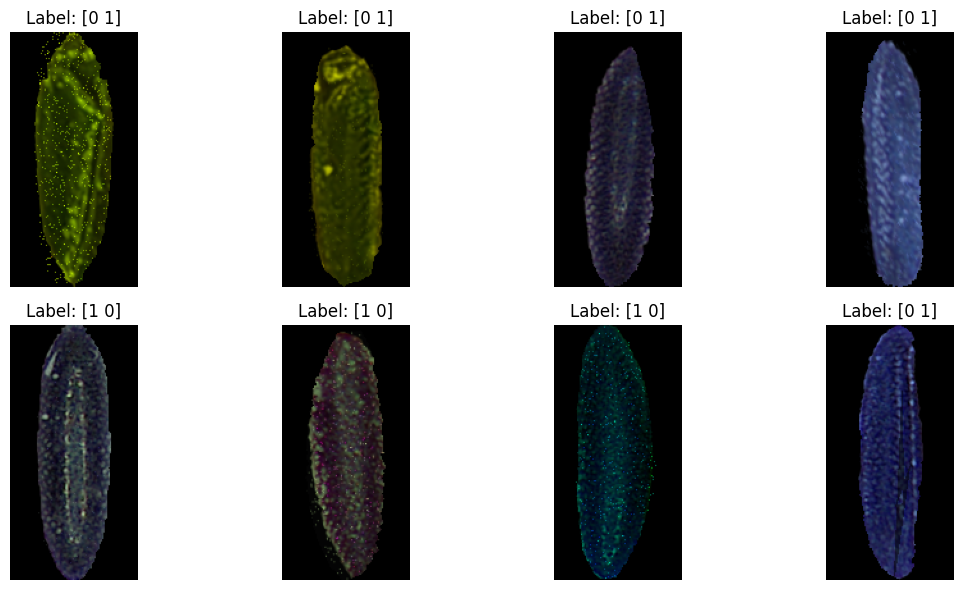

2025-09-23 07:18:54.364082: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# Einen Batch extrahieren
for images, labels in train_ds.take(1):
    images = images.numpy()
    labels = labels.numpy()

    # Zeige einige Bilder
    plt.figure(figsize=(12, 6))
    for i in range(min(8, len(images))):  # max 8 Bilder anzeigen
        plt.subplot(2, 4, i+1)
        img = images[i]
        img = img.astype(np.uint8)
        plt.imshow(img)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Model Training

In [7]:
#weight_for_albo = (1 / sum(single_egg_df['species'] == 'albopictus')) * (len(single_egg_df))
#weight_for_aegy = (1 / sum(single_egg_df['species'] == 'aegypti')) * (len(single_egg_df))

#class_weight = {0: weight_for_albo, 1: weight_for_aegy}
#print('Weight for class 0: {:.2f}'.format(weight_for_albo))
#print('Weight for class 1: {:.2f}'.format(weight_for_aegy))

In [6]:
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(height, width, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    #layers.Flatten(),
    #layers.GlobalAveragePooling2D(),
    layers.GlobalMaxPooling2D(),
    #layers.Dropout(rate=0.25),
    #layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')
])

In [16]:
wandb.init(project="egg-classification", config={
    "architecture": "EfficientNetV2B0",
    "input_shape": (height, width, 3),
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "optimizer": "adamw",
    "loss": "categorical_crossentropy",
    "num_classes": 2
})


local_checkpoint = ModelCheckpoint(
    filepath="models/model.{epoch:02d}.h5",
    save_best_only=True,
    save_weights_only=False
)

#wandb_checkpoint = WandbModelCheckpoint(
#    filepath="models-wandb/model-{epoch:02d}.keras",
#    save_best_only=True
#)

optimizer = keras.optimizers.AdamW(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              )

history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=[WandbMetricsLogger(),
                               #wandb_checkpoint                               
                                ],
                    #class_weight=class_weight
                    )

'''y_true = []
y_pred = []

for x, y in val_ds:
    preds = model.predict(x)
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(
    probs=None,
    y_true=y_true,
    preds=y_pred,
    class_names=["aegypti", "albopictus"]
)})'''

wandb.finish()

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.5418 - loss: 1.0294 - val_accuracy: 0.5782 - val_loss: 0.8494
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5450 - loss: 0.9659 - val_accuracy: 0.6021 - val_loss: 0.8100
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5409 - loss: 0.9566 - val_accuracy: 0.5968 - val_loss: 0.7796
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5727 - loss: 0.8602 - val_accuracy: 0.5411 - val_loss: 0.8780
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5542 - loss: 0.8696 - val_accuracy: 0.5676 - val_loss: 0.7929
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5631 - loss: 0.8378 - val_accuracy: 0.6101 - val_loss: 0.7315
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5455 - loss: 0.8571 - val_accuracy: 0.5862 - val_loss: 0.7509
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5520 - loss: 0.8187 - val_accuracy: 0.6286 - val_los

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch/accuracy,▁▃▃▂▄▃▅▄▆▄▄▅▅▃▅▅▅▆▅▇▅▆▆▆▆▆▇▆▇█▆▇▆▇███▇██
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▅▅▄▃▄▄▄▂▃▂▂▂▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂▁▁▁▁
epoch/val_accuracy,▃▄▄▁▂▃▆▅▅▅▆▄▅▄▄▄▅▅▇▇█▃▆███▇▆▆▇▄▇▆▆█▇▆▇▆▇
epoch/val_loss,▇▆▅█▆▅▃▃▃▃▃▂▄▃▃▂▃▂▂▂▂▂▅▂▁▁▂▂▂▂▄▁▂▂▁▁▁▁▁▁
epoch/accuracy,0.62566
epoch/epoch,49
epoch/learning_rate,0.0001
epoch/loss,0.6941
epoch/val_accuracy,0.66578
